# Monte Carlo Methods

In this notebook, you will write your own implementations of many Monte Carlo (MC) algorithms. 

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

### Part 0: Explore BlackjackEnv

We begin by importing the necessary packages.

In [2]:
import sys
import gymnasium as gym
import numpy as np
from collections import defaultdict

from plot_utils import plot_blackjack_values, plot_policy

Use the code cell below to create an instance of the [Blackjack](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py) environment.

In [3]:
env = gym.make('Blackjack-v1')

Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:

```
    STICK = 0
    HIT = 1
```
Verify this by running the code cell below.

In [4]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


Execute the code cell below to play Blackjack with a random policy.  

(_The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to get some experience with the output that is returned as the agent interacts with the environment._)

In [5]:
for i_episode in range(3):
    state = env.reset()
    while True:
        print(state)
        action = env.action_space.sample()
        print(action)
        state, reward, done, truncated, info = env.step(action)
        print("state: " + str(state[0]) + "\n")
        print("reward: " + str(reward) + "\n")
        print("done: " + str(done) + "\n")
        print("truncated: " + str(truncated) + "\n")
        print("info: " + str(info) + "\n")
        if done:
            print('End game! Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

((20, 8, False), {})
1
state: 30

reward: -1.0

done: True

truncated: False

info: {}

End game! Reward:  -1.0
You lost :(

((13, 10, True), {})
1
state: 19

reward: 0.0

done: False

truncated: False

info: {}

(19, 10, True)
1
state: 18

reward: 0.0

done: False

truncated: False

info: {}

(18, 10, False)
0
state: 18

reward: 1.0

done: True

truncated: False

info: {}

End game! Reward:  1.0
You won :)

((14, 9, True), {})
0
state: 14

reward: -1.0

done: True

truncated: False

info: {}

End game! Reward:  -1.0
You lost :(



### Part 1: MC Prediction

In this section, you will write your own implementation of MC prediction (for estimating the action-value function).  

We will begin by investigating a policy where the player _almost_ always sticks if the sum of her cards exceeds 18.  In particular, she selects action `STICK` with 80% probability if the sum is greater than 18; and, if the sum is 18 or below, she selects action `HIT` with 80% probability.  The function `generate_episode_from_limit_stochastic` samples an episode using this policy. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [6]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset()[0]
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, truncated, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

Execute the code cell below to play Blackjack with the policy. 

(*The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to gain some familiarity with the output of the `generate_episode_from_limit_stochastic` function.*)

In [7]:
for i in range(3):
    print(generate_episode_from_limit_stochastic(env))

[((18, 8, False), 1, 0.0), ((21, 8, False), 0, 1.0)]
[((17, 10, False), 1, -1.0)]
[((18, 3, True), 1, 0.0), ((17, 3, False), 1, -1.0)]


Now, you are ready to write your own implementation of MC prediction.  Feel free to implement either first-visit or every-visit MC prediction; in the case of the Blackjack environment, the techniques are equivalent.

Your algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

In [8]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # update progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        # generate episode
        episode = generate_episode(env)
        
        # create discount array (not strictly necessary for now, but was good practice)
        running_gamma = gamma
        discounts = [gamma]
        for i in range(len(episode) - 1):
            running_gamma *= gamma
            discounts.append(running_gamma)

        # loop through steps, following the first-visit MC paradigm
        visited_states = set()
        for i, step in enumerate(episode):
            state, action, reward = step
            reward = reward * running_gamma
            running_gamma *= gamma
            if not state in visited_states:
                visited_states.add(state)
                
                new_reward = sum(np.multiply([s[2] for s in episode[i:len(episode)]], discounts[i:len(discounts)]))
                
                returns_sum[state][action] += new_reward
                N[state][action] += 1
                Q[state][action] = returns_sum[state][action] / N[state][action]
    
    return Q

In [9]:
Q = mc_prediction_q(env, 10, generate_episode_from_limit_stochastic)
for state in Q.keys():
    print(state)
    print(Q[state], "\n")

(12, 8, False)
[ 0. -1.] 

(14, 8, False)
[ 0. -1.] 

(17, 8, False)
[ 0. -1.] 

(8, 10, False)
[ 0. -1.] 

(18, 10, False)
[-1.  0.] 

(20, 5, False)
[-1.  0.] 

(19, 10, True)
[-1.  0.] 

(11, 10, False)
[ 0. -1.] 

(16, 10, False)
[ 0.  -0.5] 

(19, 5, True)
[0. 0.] 

(18, 5, False)
[0. 1.] 

(19, 5, False)
[1. 0.] 

(13, 10, False)
[ 0.  -0.5] 

(17, 10, False)
[ 0. -1.] 

(9, 1, False)
[0. 1.] 

(19, 1, False)
[1. 0.] 

(20, 10, False)
[0. 0.] 



Use the cell below to obtain the action-value function estimate $Q$.  We have also plotted the corresponding state-value function.

To check the accuracy of your implementation, compare the plot below to the corresponding plot in the solutions notebook **Monte_Carlo_Solution.ipynb**.

Episode 5000/5000.

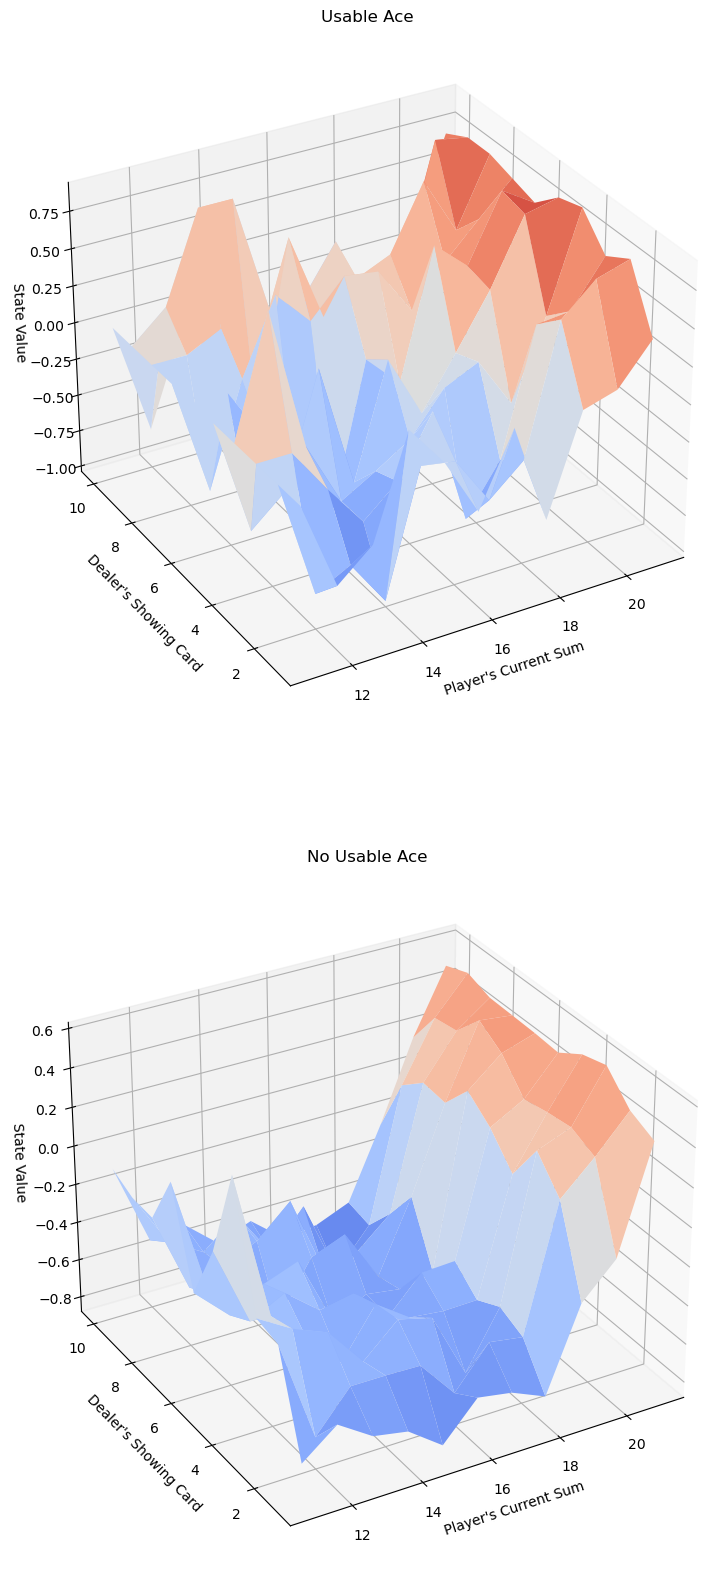

In [11]:
# obtain the action-value function
Q = mc_prediction_q(env, 5000, generate_episode_from_limit_stochastic)

# obtain the corresponding state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)

### Part 2: MC Control

In this section, you will write your own implementation of constant-$\alpha$ MC control.  

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.

(_Feel free to define additional functions to help you to organize your code._)

In [12]:
environ = gym.make('Blackjack-v1')
environ.observation_space

Tuple(Discrete(32), Discrete(11), Discrete(2))

In [13]:
def generate_episode_from_policy(bj_env, policy, epsilon, nA):
    episode = []
    state = bj_env.reset()[0]
    while True:
        # find current greedy action (highest value)
        greedy_action = np.argmax(policy[state])
        
        # calculate probabilities following epsilon-greedy paradigm    
        probs = nA*[epsilon/nA]
        probs[greedy_action] += 1-epsilon
        
        # generate action based on those epsilon probabilities
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, truncated, info = bj_env.step(action)
        
        # append state to episode
        episode.append((state, action, reward))
        
        # next state!
        state = next_state
        
        if done:
            break
    return episode


def mc_control(env, num_episodes, alpha, gamma=.95, epsilon=1, min_epsilon=.05, epsilon_decay = .99999):
    nA = env.action_space.n
    
    # initialize empty dictionary of arrays (all lambda function is doing is defaulting unseen 
    # key's values to an array of 0s, in the length of the action space (in this case, 2 (hit, stay))
    Q = defaultdict(lambda: np.zeros(nA))
    policy = defaultdict(lambda: np.zeros(nA));
    
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        if (i_episode != 1 and epsilon > min_epsilon):
            epsilon *= epsilon_decay
            
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
            
        episode = generate_episode_from_policy(env, policy, epsilon, nA)
        
        #calculate array of gamma reductions for use in calculating reward for a given state-action pair
        running_gamma = gamma
        discounts = [running_gamma]
        for i in range(len(episode) - 1):
            running_gamma *= gamma
            discounts.append(running_gamma)
        
        

        # loop through steps, following the constant-alpha MC control paradigm
        visited_states = set()
        for i, step in enumerate(episode):
            state, action, reward = step
            
            if not state in visited_states:
                visited_states.add(state)
                
                new_reward = sum(np.multiply([s[2] for s in episode[i:len(episode)]], discounts[i:len(discounts)]))
                
                # Q[state][action] will return [0, 0] if never visited in any episode before
                Q[state][action] = (1-alpha)*Q[state][action] + alpha*(new_reward - Q[state][action])
                
                # update policy if updated action is now more "valuable" than other action in that state,
                # otherwise keep policy[state] the same
                policy[state] = action if action == np.argmax(Q[state]) else policy[state]
                    
    
    # done!                
    return policy, Q

Use the cell below to obtain the estimated optimal policy and action-value function.  Note that you should fill in your own values for the `num_episodes` and `alpha` parameters.

In [14]:
# obtain the estimated optimal policy and action-value function
policy, Q = mc_control(env, 100000000, .005)

Episode 100000000/100000000.

Next, we plot the corresponding state-value function.

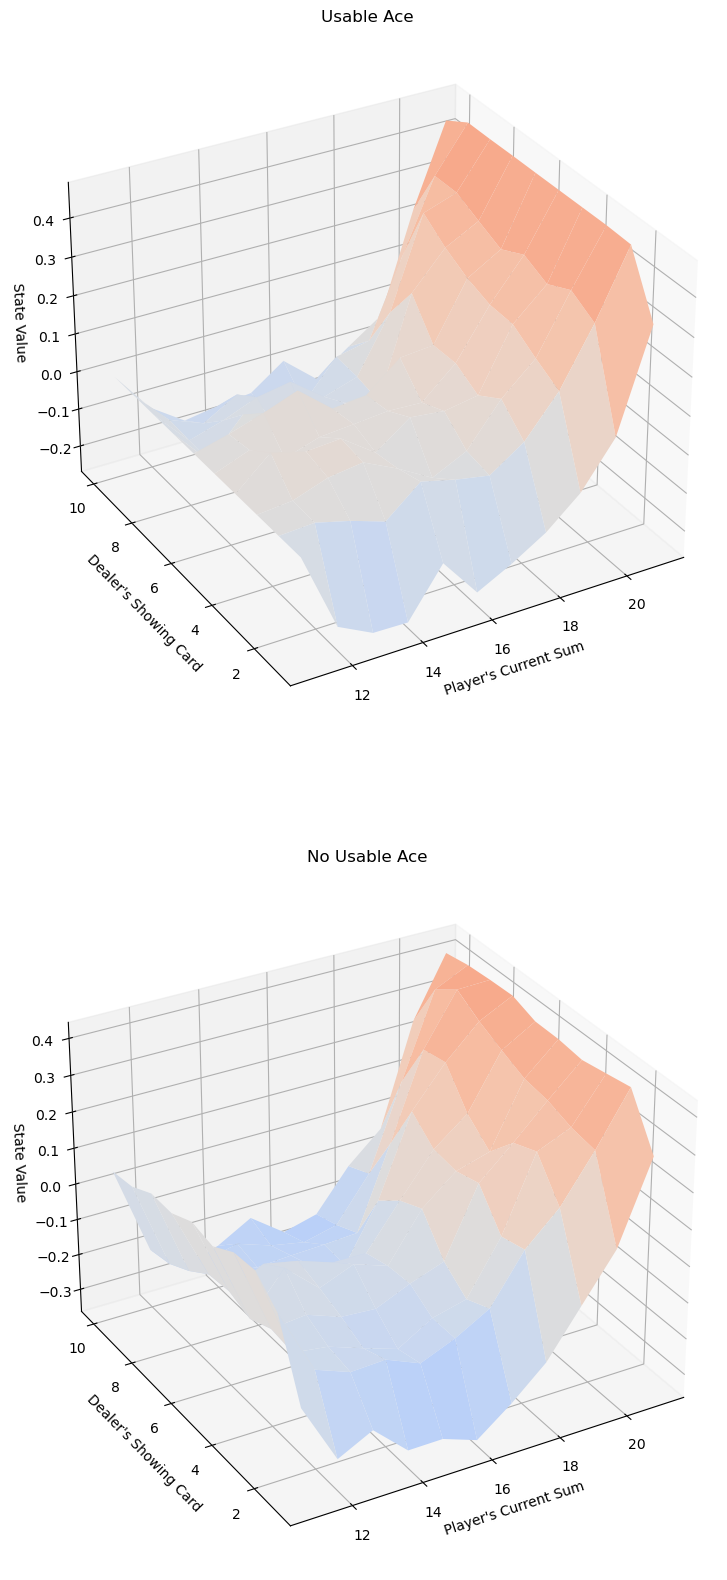

In [15]:
from plot_utils import plot_blackjack_values, plot_policy

# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

In [16]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [17]:

def plot_policy(policy):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in policy:
            return policy[x,y,usable_ace]
        else:
            return 1

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(10, 0, -1)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(x,y,usable_ace) for x in x_range] for y in y_range])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2), vmin=0, vmax=1, extent=[10.5, 21.5, 0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_ylabel('Player\'s Current Sum')
        ax.set_xlabel('Dealer\'s Showing Card')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])
            
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

Finally, we visualize the policy that is estimated to be optimal.

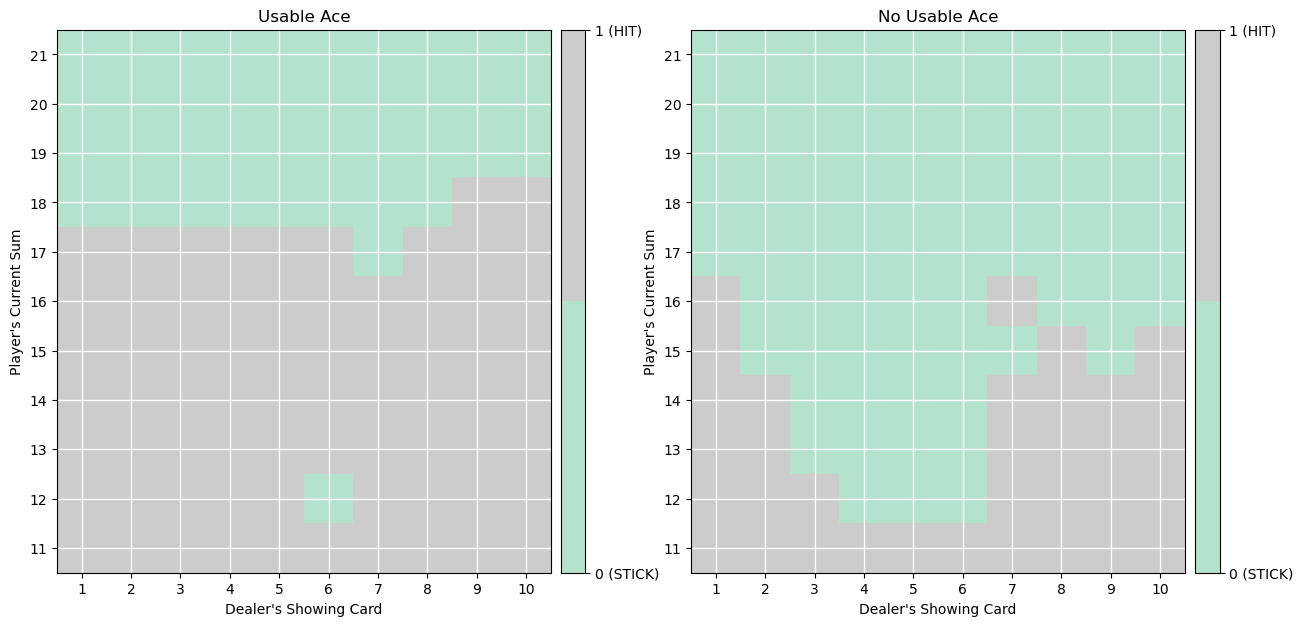

In [18]:
# plot the policy
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)


def get_Z(x, y, usable_ace):
        if (x, y,usable_ace) in policy:
            return policy[x,y,usable_ace]
        else:
            return 1

def get_figure(usable_ace, ax):
    y_range = np.arange(21, 10, -1)
    x_range = np.arange(1, 11)
    X, Y = np.meshgrid(x_range, y_range)
    Z = np.array([[get_Z(y,x,usable_ace) for x in x_range] for y in y_range])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2), vmin=0, vmax=1, extent=[0.5, 10.5, 10.5, 21.5])
    plt.xticks(x_range)
    plt.yticks(y_range)
    # plt.gca().invert_yaxis()
    ax.set_ylabel('Player\'s Current Sum')
    ax.set_xlabel('Dealer\'s Showing Card')
    ax.grid(color='w', linestyle='-', linewidth=1)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
    cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])
            
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(121)
ax.set_title('Usable Ace')
get_figure(True, ax)
ax = fig.add_subplot(122)
ax.set_title('No Usable Ace')
get_figure(False, ax)
plt.show()

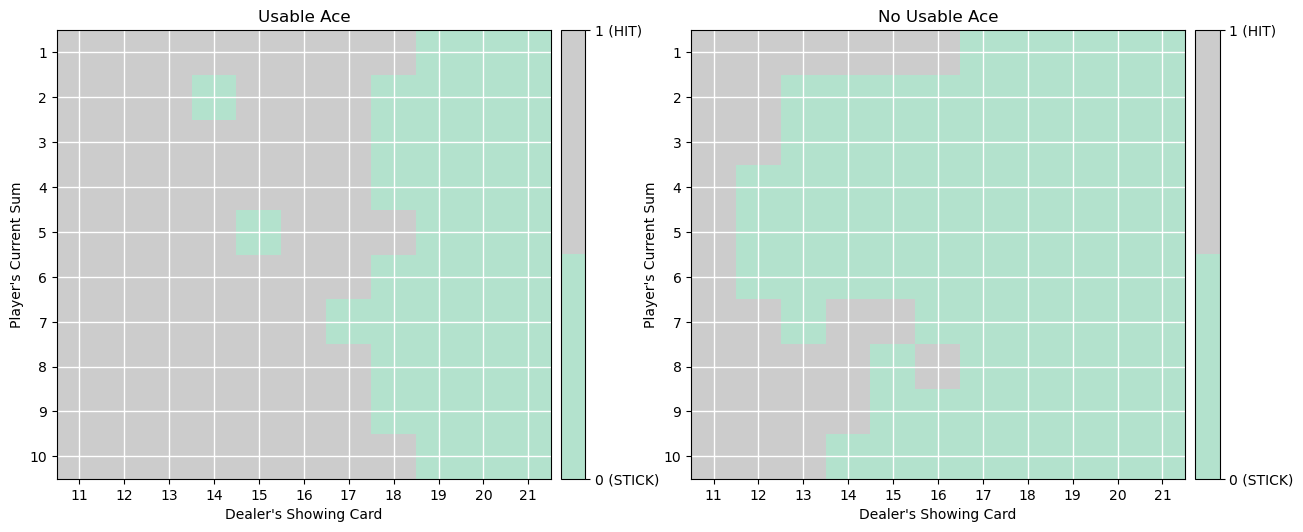

In [507]:
plot_policy(policy)

The **true** optimal policy $\pi_*$ can be found in Figure 5.2 of the [textbook](http://go.udacity.com/rl-textbook) (and appears below).  Compare your final estimate to the optimal policy - how close are you able to get?  If you are not happy with the performance of your algorithm, take the time to tweak the decay rate of $\epsilon$, change the value of $\alpha$, and/or run the algorithm for more episodes to attain better results.

![True Optimal Policy](images/optimal.png)